In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')    
device

device(type='cuda')

In [13]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
ids = os.listdir(train_path)
os.makedirs('/kaggle/data_dir/',exist_ok=True)

In [14]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

In [15]:
for i in ids:
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    mask=np.load(f'{train_path}/{i}/human_pixel_masks.npy')
    directory = f'/kaggle/data_dir/{i}/'
    os.makedirs(directory, exist_ok=True)
    np.save(os.path.join(directory, 'false.npy'), image)
    np.save(os.path.join(directory, 'mask.npy'), mask)

In [16]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.ids = os.listdir(self.path)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,idx):
        id = ids[idx]
        image = np.load(f'{self.path}/{id}/false.npy')
        mask = np.load(f'{self.path}/{id}/mask.npy')
        image = torch.from_numpy(image)
        image = torch.moveaxis(image,-1,0)
        mask = torch.from_numpy(mask)
        mask=torch.moveaxis(mask,-1,0)
        return image,mask.float()

In [17]:
train_dataset = CustomDataset('/kaggle/data_dir')

In [18]:
train_dataloader = DataLoader(train_dataset,batch_size=64, shuffle=True)

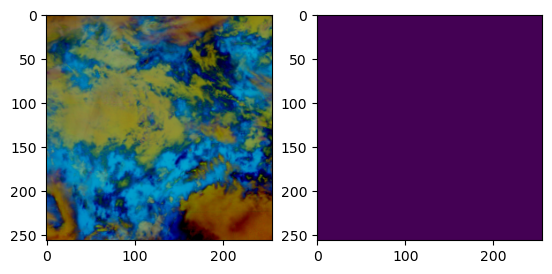

In [19]:
test_image , test_mask = next(iter(train_dataloader))
test_image = torch.moveaxis(test_image,1,-1)
test_mask = torch.moveaxis(test_mask,1,-1)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image[2])
fig[1].imshow(test_mask[2])

In [20]:
model = smp.Unet(encoder_name='resnet34',encoder_weights='imagenet',in_channels=3,classes=1)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.4MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [21]:
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [22]:
def Dice_loss(pred, mask):
    
    smooth = 1e-6  # Smoothing factor to avoid division by zero
        
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

    

In [25]:
os.makedirs('/kaggle/working/savedmodel')

In [26]:
learning_rate = 0.005
losses = []
epochs=40
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience = 4, factor = 0.31622776601, verbose = True)
best_score = 0
best_dice_epoch = 0
for epoch in range(epochs):
    batch_dice_score = 0
    net_dice_loss = 0
    if(epoch - best_dice_epoch > 10):
        print(f'early stopped due to no improvement in last 10 epochs')
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/last_run_epoch.pt')
        break
    for image , mask in tqdm(train_dataloader):
        image,mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = Dice_loss(pred,mask)
        loss.backward()
        optimizer.step()
        batch_dice_score += (1-loss)
        net_dice_loss +=loss
    losses.append(net_dice_loss)
    print(f'at {epoch}th the dice loss is {net_dice_loss}')
    if(best_score<batch_dice_score):
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/{epoch}th_epoch.pt')
        torch.save(model,f'{epoch}th_model.pt')
        best_score = batch_dice_score
        best_dice_epoch = epoch

  0%|          | 0/321 [00:00<?, ?it/s]

at 0th the dice loss is 315.1108093261719


  0%|          | 0/321 [00:00<?, ?it/s]

at 1th the dice loss is 312.908203125


  0%|          | 0/321 [00:00<?, ?it/s]

at 2th the dice loss is 321.1177978515625


  0%|          | 0/321 [00:00<?, ?it/s]

at 3th the dice loss is 309.0892333984375


  0%|          | 0/321 [00:00<?, ?it/s]

at 4th the dice loss is 297.65576171875


  0%|          | 0/321 [00:00<?, ?it/s]

at 5th the dice loss is 289.5456848144531


  0%|          | 0/321 [00:00<?, ?it/s]

at 6th the dice loss is 305.36004638671875


  0%|          | 0/321 [00:00<?, ?it/s]

at 7th the dice loss is 315.8165283203125


  0%|          | 0/321 [00:00<?, ?it/s]

at 8th the dice loss is 318.01300048828125


  0%|          | 0/321 [00:00<?, ?it/s]

at 9th the dice loss is 316.166015625


  0%|          | 0/321 [00:00<?, ?it/s]

at 10th the dice loss is 318.2262878417969


  0%|          | 0/321 [00:00<?, ?it/s]

at 11th the dice loss is 317.8719787597656


  0%|          | 0/321 [00:00<?, ?it/s]

at 12th the dice loss is 316.1714172363281


  0%|          | 0/321 [00:00<?, ?it/s]

at 13th the dice loss is 344.4796142578125


  0%|          | 0/321 [00:00<?, ?it/s]

at 14th the dice loss is 289.3891296386719


  0%|          | 0/321 [00:00<?, ?it/s]

at 15th the dice loss is 281.15478515625


  0%|          | 0/321 [00:00<?, ?it/s]

at 16th the dice loss is 271.0179443359375


  0%|          | 0/321 [00:00<?, ?it/s]

at 17th the dice loss is 264.79669189453125


  0%|          | 0/321 [00:00<?, ?it/s]

at 18th the dice loss is 252.17164611816406


  0%|          | 0/321 [00:00<?, ?it/s]

at 19th the dice loss is 212.5550994873047


  0%|          | 0/321 [00:00<?, ?it/s]

at 20th the dice loss is 286.1080017089844


  0%|          | 0/321 [00:00<?, ?it/s]

at 21th the dice loss is 263.03125


  0%|          | 0/321 [00:00<?, ?it/s]

at 22th the dice loss is 270.091552734375


  0%|          | 0/321 [00:00<?, ?it/s]

at 23th the dice loss is 310.3099365234375


  0%|          | 0/321 [00:00<?, ?it/s]

at 24th the dice loss is 284.1149597167969


  0%|          | 0/321 [00:00<?, ?it/s]

at 25th the dice loss is 314.7530212402344


  0%|          | 0/321 [00:00<?, ?it/s]

at 26th the dice loss is 304.8203125


  0%|          | 0/321 [00:00<?, ?it/s]

at 27th the dice loss is 292.66259765625


  0%|          | 0/321 [00:00<?, ?it/s]

at 28th the dice loss is 328.4462890625


  0%|          | 0/321 [00:00<?, ?it/s]

at 29th the dice loss is 317.82269287109375
early stopped due to no improvement in last 10 epochs


In [41]:
for  i in range(len(losses)):
    losses[i] = losses[i].detach().to('cpu').to(dtype=torch.uint8)

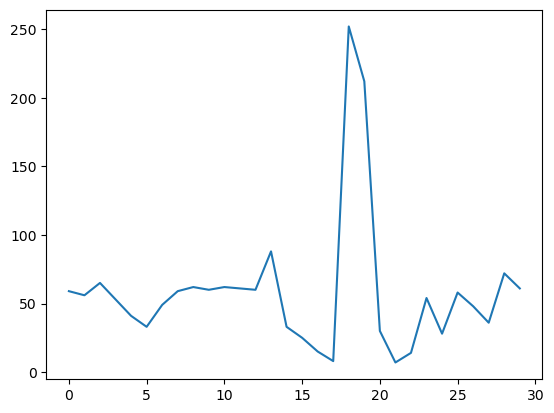

In [43]:
plt.plot(losses)